## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import pandas as pd
import requests

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [2]:
page, page_size = 1, 20
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
print(url)

https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1


#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
response.text[:200]

'[{"localTradedAt":"2022-07-08","closePrice":"2,350.61","compareToPreviousClosePrice":"16.34","compareToPreviousPrice":{"code":"2","text":"상승","name":"RISING"},"fluctuationsRatio":"0.70","openPrice":"2'

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [5]:
columns = ["localTradedAt", "closePrice"]
datas = response.json()
kospi_df = pd.DataFrame(datas)[columns]
kospi_df.tail(2)

,localTradedAt,closePrice
18,2022-06-14,"2,492.97"
19,2022-06-13,"2,504.51"


#### 4. 함수로 만들기

In [6]:
def stock_price(code="KOSPI", page=1, page_size=20):
    """ This function is crwaling stock price from naver stock web page
    parameters :
        code : str : KOSPI or KOSDAQ
        page : int : page number
        page_size : int : one page size
    return :
        type : DataFame of pandas"""
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'
    response = requests.get(url)
    columns = ["localTradedAt", "closePrice"]
    datas = response.json()
    return pd.DataFrame(datas)[columns]

In [7]:
help(stock_price)

Help on function stock_price in module __main__:

stock_price(code='KOSPI', page=1, page_size=20)
    This function is crwaling stock price from naver stock web page
    parameters :
        code : str : KOSPI or KOSDAQ
        page : int : page number
        page_size : int : one page size
    return :
        type : DataFame of pandas



In [8]:
kospi_df = stock_price()
kospi_df.tail(2)

,localTradedAt,closePrice
18,2022-06-14,"2,492.97"
19,2022-06-13,"2,504.51"


In [9]:
kosdaq_df = stock_price("KOSDAQ")
kosdaq_df.tail(2)

,localTradedAt,closePrice
18,2022-06-14,823.58
19,2022-06-13,828.77


#### 5. 원달러 환율 데이터 수집 : 실습

In [10]:
def exchage_rate(code="FX_USDKRW", page=1, page_size=60):
    url = f'https://api.stock.naver.com/marketindex/exchange/{code}/prices?page={page}\
&pageSize={page_size}'
    response = requests.get(url)
    columns = ["localTradedAt", "closePrice"]
    datas = response.json()
    return pd.DataFrame(datas)[columns]

In [11]:
usd_df = exchage_rate()
usd_df.tail(2)

,localTradedAt,closePrice
58,2022-04-14,"1,227.50"
59,2022-04-13,"1,228.50"


In [12]:
eur_df = exchage_rate("FX_EURKRW")
eur_df.tail(2)

,localTradedAt,closePrice
58,2022-04-14,"1,338.71"
59,2022-04-13,"1,330.10"


#### 6. 시각화

In [13]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 데이터 수집
page_size = 60
kospi_df = stock_price("KOSPI", page_size=page_size)
kosdaq_df = stock_price("KOSDAQ", page_size=page_size)
usd_df = exchage_rate("FX_USDKRW", page_size=page_size)
eur_df = exchage_rate("FX_EURKRW", page_size=page_size)

In [16]:
# 데이터 전처리 1 : 데이터 타입 변경
print(kospi_df.dtypes)
kospi_df["kospi"] = kospi_df["closePrice"].apply(lambda data: float(data.replace(",", "")))
kospi_df = kospi_df.drop(columns=["closePrice"])
print(kospi_df.dtypes)

localTradedAt    object
closePrice       object
dtype: object
localTradedAt     object
kospi            float64
dtype: object


In [17]:
kosdaq_df["kosdaq"] = kosdaq_df["closePrice"].apply(lambda data: float(data.replace(",", "")))
usd_df["usd"] = usd_df["closePrice"].apply(lambda data: float(data.replace(",", "")))
eur_df["eur"] = eur_df["closePrice"].apply(lambda data: float(data.replace(",", "")))

In [18]:
kosdaq_df = kosdaq_df.drop(columns=["closePrice"])
usd_df = usd_df.drop(columns=["closePrice"])
eur_df = eur_df.drop(columns=["closePrice"])

In [19]:
# 데이터 전처리 2 : 날짜 데이터 맞추기 : merge

In [20]:
merge_df_1 = pd.merge(kospi_df, kosdaq_df, on="localTradedAt")
merge_df_2 = pd.merge(merge_df_1, usd_df, on="localTradedAt")
merge_df_3 = pd.merge(merge_df_2, eur_df, on="localTradedAt")
merge_df = merge_df_3.copy()
merge_df.tail(2)

,localTradedAt,kospi,kosdaq,usd,eur
58,2022-04-14,2716.71,928.01,1227.5,1338.71
59,2022-04-13,2716.49,927.31,1228.5,1330.10


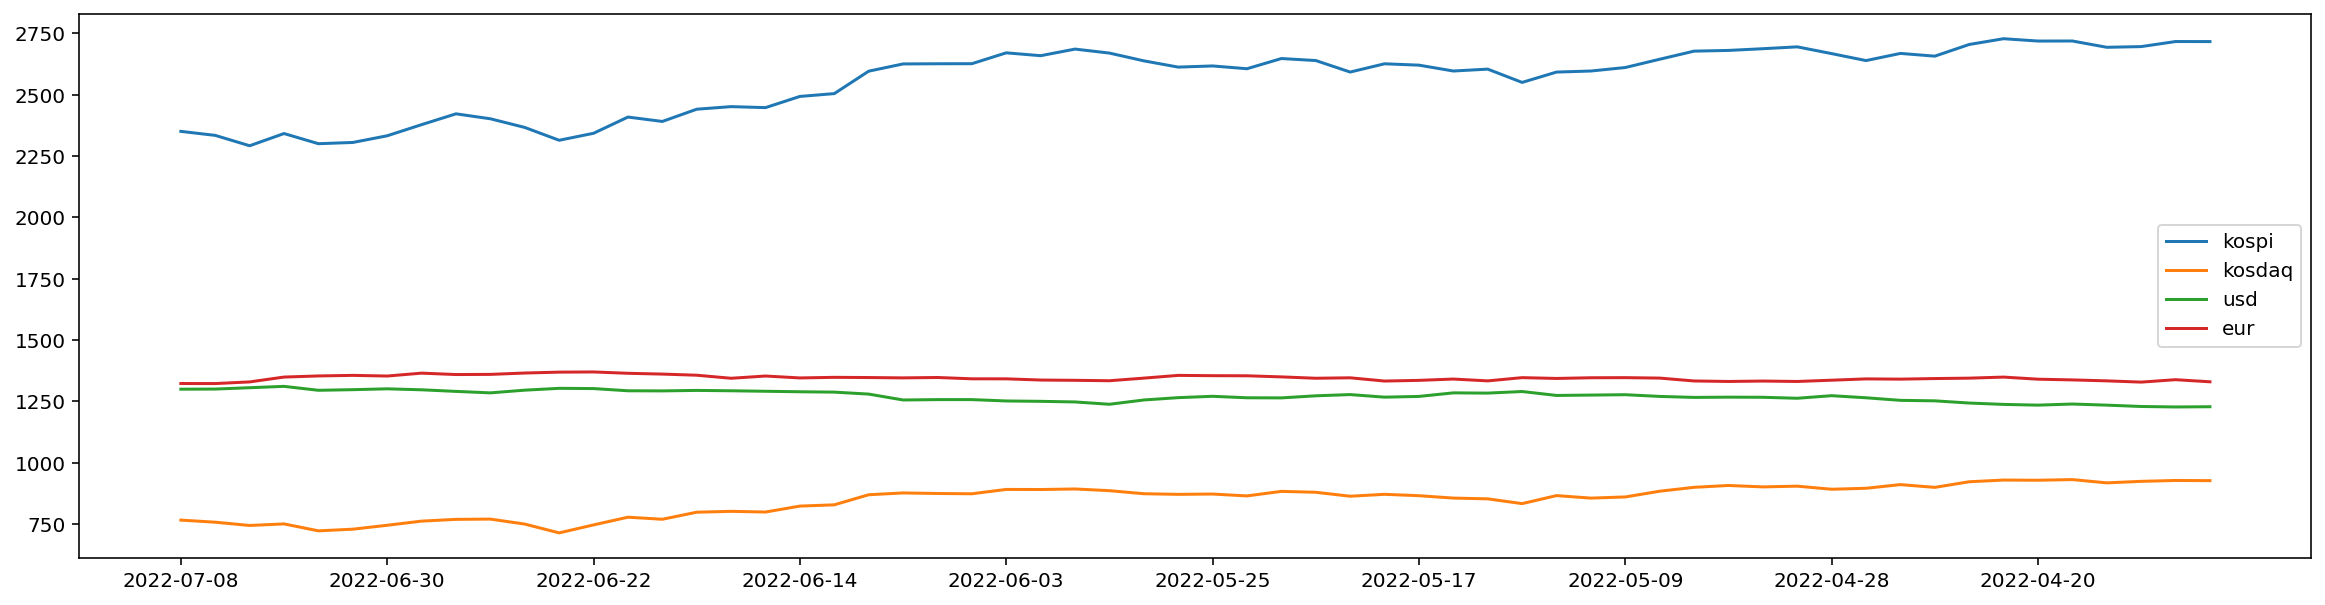

In [21]:
# 시각화
plt.figure(figsize=(20, 5))

# plt.plot(merge_df["localTradedAt"], merge_df["kospi"], label="kospi")
# plt.plot(merge_df["localTradedAt"], merge_df["kosdaq"], label="kosdaq")
# plt.plot(merge_df["localTradedAt"], merge_df["usd"], label="usd")
# plt.plot(merge_df["localTradedAt"], merge_df["eud"], label="eur")

columns = merge_df.columns[1:]
for column in columns:
    plt.plot(merge_df["localTradedAt"], merge_df[column], label=column)
    
xticks_count = 11
plt.xticks(merge_df["localTradedAt"][::int(len(merge_df) // xticks_count) + 1])
plt.legend(loc=0)
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [22]:
from sklearn.preprocessing import minmax_scale

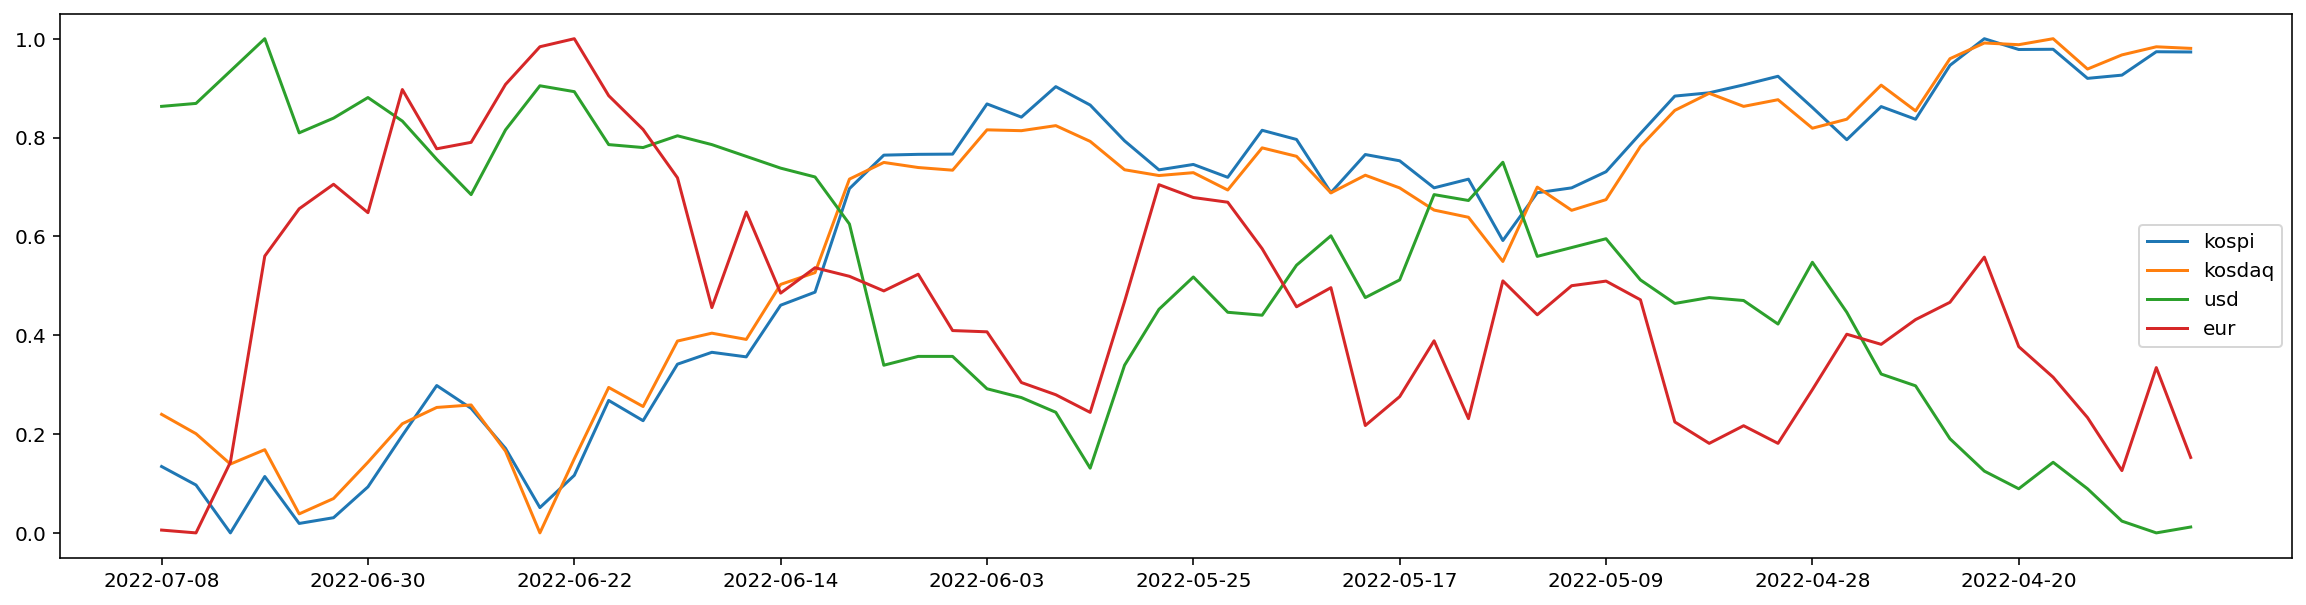

In [23]:
# 시각화
plt.figure(figsize=(20, 5))

columns = merge_df.columns[1:]
for column in columns:
    plt.plot(merge_df["localTradedAt"], minmax_scale(merge_df[column]), label=column)
    
xticks_count = 11
plt.xticks(merge_df["localTradedAt"][::int(len(merge_df) // xticks_count) + 1])
plt.legend(loc=0)
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [24]:
# 해석 1 : kospi, kosdaq은 아주 강한 양의 상관관계를 갖는다. (데이터가 같은 방향으로 움직임)
# 해석 2 : kospi와 usd를 강한 음의 상관관계를 갖는다. (데이터가 반대 방향으로 움직임)
corr_df = merge_df[merge_df.columns[1:]].corr()
corr_df

,kospi,kosdaq,usd,eur
kospi,1.000000,0.991273,-0.885754,-0.500534
kosdaq,0.991273,1.000000,-0.896188,-0.541728
usd,-0.885754,-0.896188,1.000000,0.452319
eur,-0.500534,-0.541728,0.452319,1.000000


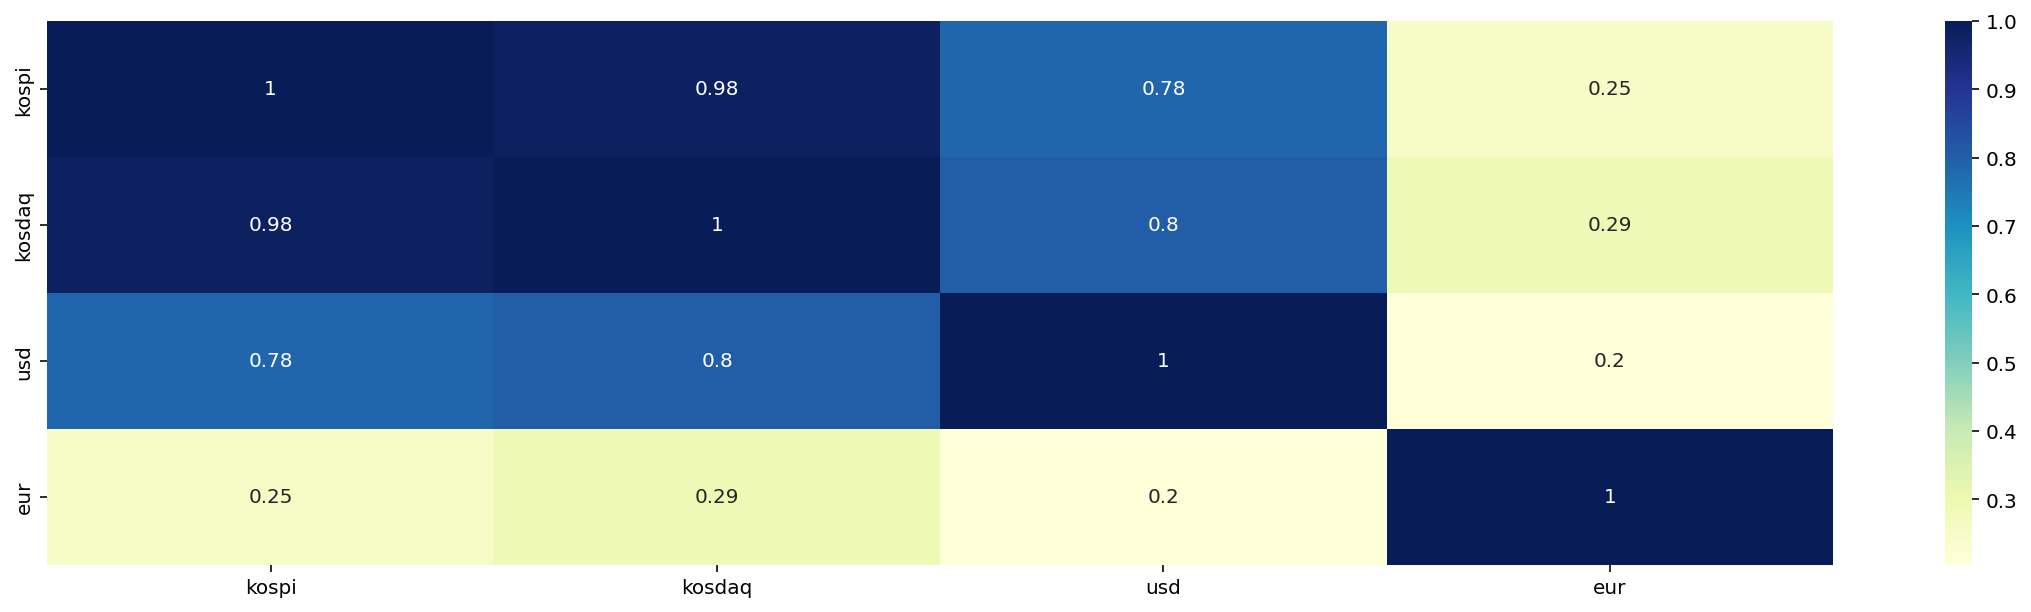

In [25]:
# 결정계수 : r-squared 
# 1과 가까울수록 강한 관계, 0과 가까울수록 약한 관계
plt.figure(figsize=(20, 5))
sns.heatmap(corr_df**2, cmap="YlGnBu", annot=True)
plt.show()